In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from glob import glob
from xgcm import Grid

%matplotlib inline

In [2]:
chunks = {'ocean_time':1}
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_avg1/outer_avg_0[1]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_avg_01*.nc')

ds = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

In [3]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

In [4]:
ds.Hvom_temp

<xarray.DataArray 'Huon_temp' (ocean_time: 12, s_rho: 30, eta_rho: 317, xi_u: 271)>
dask.array<concatenate, shape=(12, 30, 317, 271), dtype=float32, chunksize=(1, 30, 317, 271), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_u       (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-16T12:00:00 ... 1994-12-1...
Dimensions without coordinates: eta_rho, xi_u
Attributes:
    long_name:  time-averaged potential temperature u-volume flux
    units:      meter3 second-1 Celsius
    time:       ocean_time
    grid:       grid
    location:   edge1
    field:      Huon_temp, scalar, series

In [14]:
h_U = grid.interp(ds.h,'X')
h_V = grid.interp(ds.h,'Y')

In [16]:
ds["Huon_temp_bar"] = ds.Huon_temp.sum('s_rho').where(ds.mask_u>0)
ds["Hvom_temp_bar"] = ds.Hvom_temp.sum('s_rho').where(ds.mask_v>0)

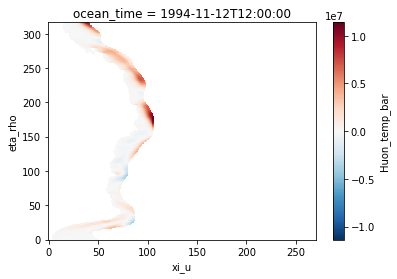

In [17]:
ds.Huon_temp_bar.isel(ocean_time=10).where(h_U<1000).plot()

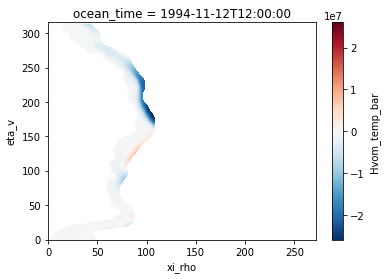

In [19]:
ds.Hvom_temp_bar.isel(ocean_time=10).where(h_V<1000).plot()